## Working with Shapes

Here we explore how to visualize information using the cell morphology

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


In [3]:
ps = h.Shape()

# ps = h.Shape(0)
# ps.view(-191.578, -172.628, 369.697, 431.069, 106, 253, 483.84, 563.2)

nrn_define_shape: soma first and last 3-d point at same (x,y)


In [4]:
ps.show(0)
# ps.show(1)

1.0

In [5]:
ic = h.IClamp(cell.soma(0.5))

In [6]:
ps.point_mark(ic, 3)

0.0

In [7]:
ic.loc(cell.dends[30](1))
ic.get_segment()

dend2_121111(1)

In [8]:
ps.point_mark_remove()

0.0

In [9]:
ps = h.PlotShape(0)
ps.view(-191.578, -172.628, 369.697, 431.069, 106, 253, 483.84, 563.2)

1.0

In [10]:
ps.variable("v")
ps.exec_menu("Shape Plot")

0.0

In [11]:
ps.scale(-70, 0)

1.0

In [12]:
ic.loc(cell.soma(0.5))

ic.delay = 0
ic.amp = 0.1
ic.dur = 100

h.v_init = -75
h.tstop = 100

h.init()
h.run()
ps.flush()

1.0

In [13]:
vs = []
for sec in h.allsec():
    for seg in sec.allseg():
        vs.append(seg.v)
        
vsmin = np.min(vs)
vsmax = np.max(vs)
print(f'min voltage: {vsmin}, max voltage: {vsmax}')

min voltage: -75.0, max voltage: -67.79725996648476


In [14]:
ps.scale(vsmin, vsmax)

1.0

In [15]:
ps.printfile("L23_voltage_1.eps")

1.0

You can plot other variables, too, with a little trick.

In [16]:
vs = []
for sec in h.allsec():
    for seg in sec.allseg():
        seg.v = h.distance(cell.soma(0.5), seg) # set the distance for soma
        vs.append(seg.v)
        
vsmin = np.min(vs)
vsmax = np.max(vs)
print(f'min voltage: {vsmin}, max voltage: {vsmax}')

ps.scale(vsmin, vsmax)

min voltage: 0.0, max voltage: 1e+20


1.0

# Building a network

Network construction in NEURON follows the following steps:

1. Prepare neurons (morphology, mechanisms, etc.) and external stimuli if necessary,
2. Embed synapse objects in each neuron,
3. Connect the neurons to the synapses via [NetCon](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html),
4. Set up recordings,
5. Run the simulation.

![](./images/net_construction.png)


Here we demonstrate two simple networks with one pyramidal neuron and one or two external stimuli.

## 1 Pyramidal cell + 1 synapse

Again, we start from importing the NEURON and cell module.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


Here we open a session that embeds a synapse object called [Exp2Syn](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=exp2syn#Exp2Syn).

In [18]:
syn = [h.Exp2Syn(cell.soma(0.5))]

nrn_define_shape: soma first and last 3-d point at same (x,y)


In [19]:
print(f'Erev = {syn[0].e}\ntau1 = {syn[0].tau1} ms\ntau2 = {syn[0].tau2} ms')

Erev = 0.0
tau1 = 0.1 ms
tau2 = 10.0 ms


Again we define our run function:

In [20]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    
    trec = h.Vector() # Record time
    vrec = h.Vector() # Record voltage
    
    trec.record(h._ref_t, dt)
    vrec.record(cell.soma(0.5)._ref_v, dt)
    
    h.v_init = -75
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return trec.c(), vrec.c() # Should return a copy of the vector

However, nothing happens during our simulation since there is no input connected to the synapse.

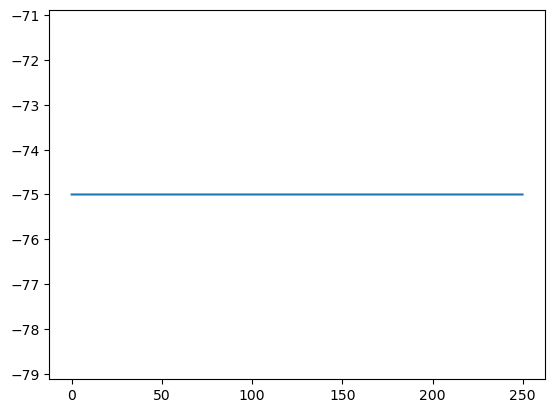

In [21]:
t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)

Therefore, we prepare an artificial spike generator called [NetStim](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=netstim#NetStim) and connect this to this synapse by a `NetCon` object.

In [22]:
# Check out the documentation for what the parameters are
stim = h.NetStim()
stim.start = 50
stim.number = 1
stim.interval = 5
stim.noise = 0

# Connect stim to our synapse
nc = h.NetCon(stim, syn[0])

Nothing happens yet since the synaptic conductance is 0. We set this to a non-zero value:

In [23]:
nc.weight[0] = 0.01 # 0.01 nS = 10 pS of the synaptic conductance

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

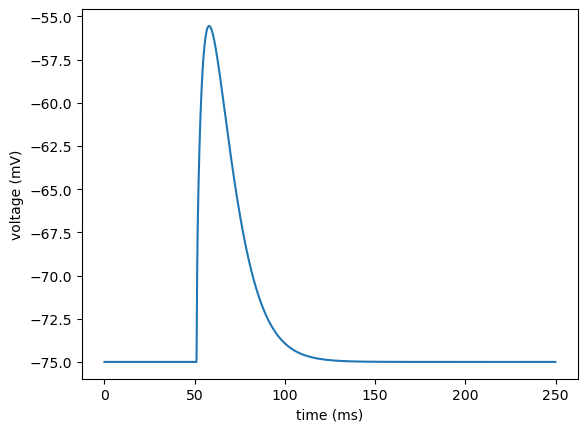

In [24]:
t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Now we see EPSPs triggered by spikes from `stim`.

In [25]:
stim.start = 50
stim.number = 5
stim.interval = 40
stim.noise = 0

## Multiple synapses

Of course, we can add more synapses!

In [26]:
syn.append(h.Exp2Syn(cell.soma(0.5)))

Here we put the spike generators and NetCons in lists:

In [27]:
stim = []
nc = []
for i in range(2):
    stim.append(h.NetStim())
    stim[i].start = 50
    stim[i].number = 1
    stim[i].noise = 0
    
    nc.append(h.NetCon(stim[i], syn[i]))
    nc[i].weight[0] = 0.01

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

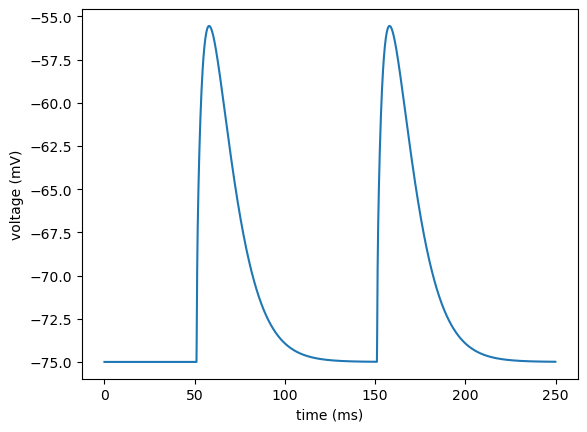

In [28]:
stim[1].start = 150

t, vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Here we move the synapses:

In [29]:
syn[0].loc(cell.dends[10](0.2))
syn[1].loc(cell.dends[10](0.8))

0.8

Let's check the locations!

In [30]:
ps = h.Shape(0)
ps.view(-191.578, -172.628, 369.697, 431.069, 106, 253, 483.84, 563.2)

1.0

In [31]:
ps.point_mark(syn[0], 2) # red
ps.point_mark(syn[1], 3) # blue

0.0

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

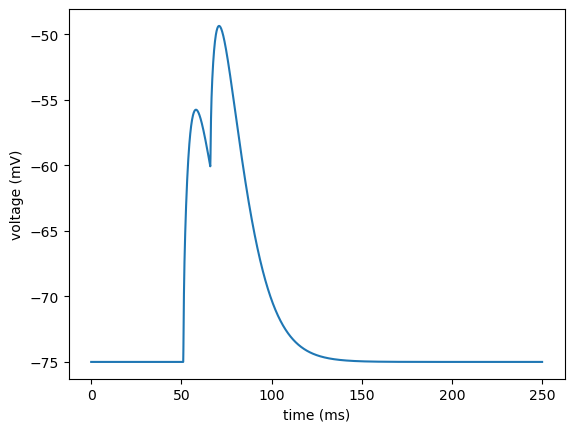

In [32]:
stim[1].start = stim[0].start+15

t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Let's try different locations

In [33]:
syn[0].loc(cell.dends[10](0.25))
syn[1].loc(cell.dends[11](0.8))

0.8

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

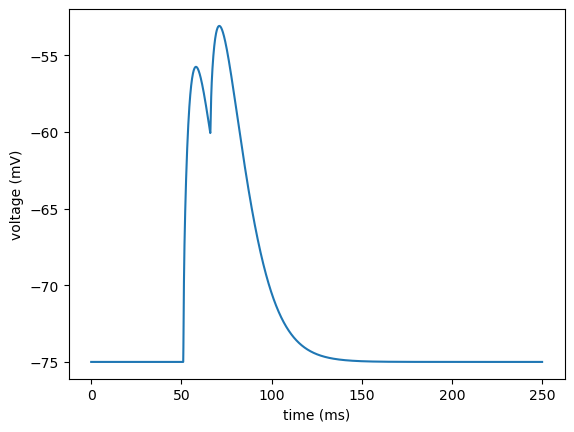

In [34]:
stim[1].start = stim[0].start+15

t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")